# Proyecto Series Temporales
### Grupo 8 - Walmart Sales
#### Integrantes:

- Diego Collado
- Iñigo Gonzalez-Varas
- Carlota Lopez
- Diego Lopez

Este trabajo trata de predecir las ventas semanales de Walmart.

Importamos las librerías necesarias para el trabajo.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import warnings
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text
from sklearn.tree import plot_tree
import seaborn as sns
from scipy import stats

warnings.filterwarnings('ignore')

## Exploración preliminar de los datos

Aqui va desde la version nueva del main

In [2]:
df = pd.read_csv('Walmart.csv')
df

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106
...,...,...,...,...,...,...,...,...
6430,45,28-09-2012,713173.95,0,64.88,3.997,192.013558,8.684
6431,45,05-10-2012,733455.07,0,64.89,3.985,192.170412,8.667
6432,45,12-10-2012,734464.36,0,54.47,4.000,192.327265,8.667
6433,45,19-10-2012,718125.53,0,56.47,3.969,192.330854,8.667


In [3]:
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')
df['Month'] = df['Date'].dt.month
df['Year']  = df['Date'].dt.year
df['Semana_del_Año'] = df['Date'].dt.isocalendar().week




In [4]:

df = df.set_index('Date')
df = df.sort_index()


In [5]:
df = df.sort_values(by = ['Date','Store'], ascending = [True, True])
df = df.reset_index()

In [6]:
df.head(5)

,Date,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Month,Year,Semana_del_Año
0,2010-02-05,1,1643690.90,0,42.31,2.572,211.096358,8.106,2,2010,5
1,2010-02-05,2,2136989.46,0,40.19,2.572,210.752605,8.324,2,2010,5
2,2010-02-05,3,461622.22,0,45.71,2.572,214.424881,7.368,2,2010,5
3,2010-02-05,4,2135143.87,0,43.76,2.598,126.442065,8.623,2,2010,5
4,2010-02-05,5,317173.10,0,39.70,2.572,211.653972,6.566,2,2010,5


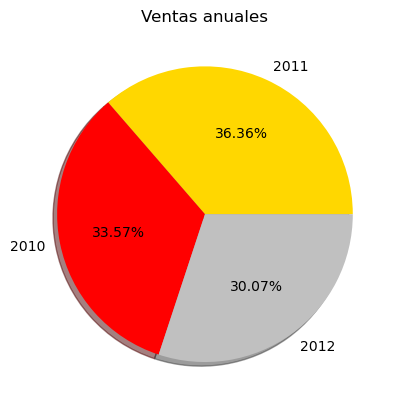

In [7]:
plt.pie(df['Year'].value_counts().values,labels =df['Year'].value_counts().index,
       autopct='%1.2f%%',shadow=True,colors=['gold','red',"silver"])
plt.title('Ventas anuales')
plt.show()

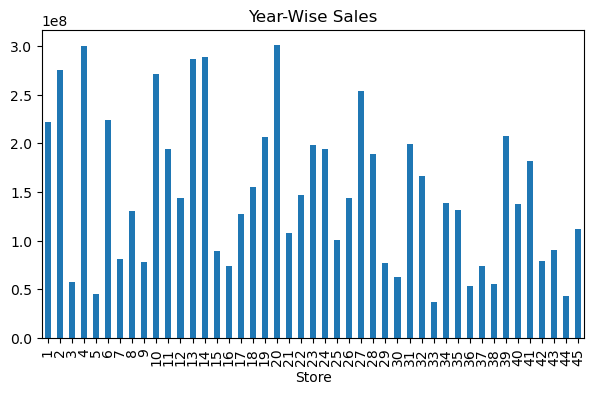

In [8]:
plt.figure(figsize=(7,4))

df.groupby('Store')['Weekly_Sales'].sum().plot(kind='bar')
plt.title('Year-Wise Sales')

plt.show()

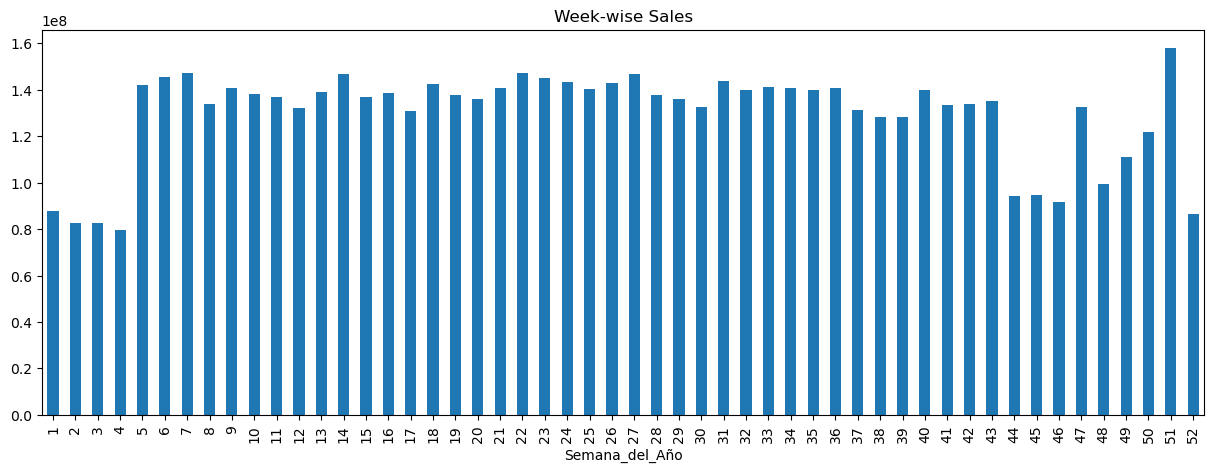

In [9]:
plt.figure(figsize=(15,5))

df.groupby(['Semana_del_Año'])['Weekly_Sales'].sum().plot(kind='bar')
plt.title('Week-wise Sales')

plt.show()

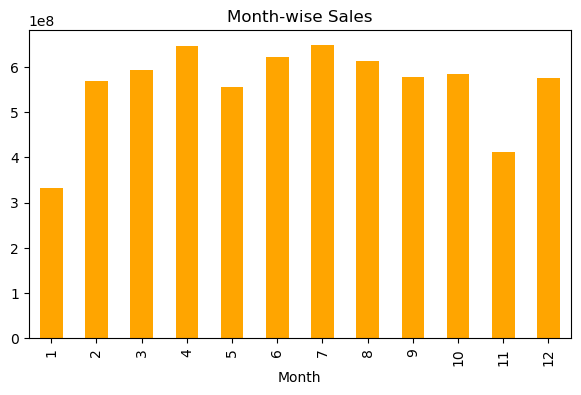

In [10]:
plt.figure(figsize=(7,4))

df.groupby('Month')['Weekly_Sales'].sum().plot(kind='bar',color='Orange')
plt.title('Month-wise Sales')

plt.show()

In [11]:
total_sales = df.groupby('Date')['Weekly_Sales'].sum().reset_index()

In [12]:
total_sales = total_sales.set_index('Date')
total_sales

,Weekly_Sales
Date,
2010-02-05,49750740.50
2010-02-12,48336677.63
2010-02-19,48276993.78
2010-02-26,43968571.13
2010-03-05,46871470.30
...,...
2012-09-28,43734899.40
2012-10-05,47566639.31
2012-10-12,46128514.25


(-321.70000000000005, 6755.7)

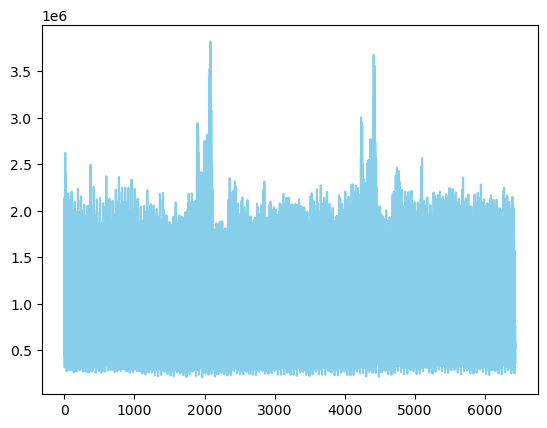

In [13]:
plt.plot(df['Weekly_Sales'], color="skyblue")
plt.xlim()

(14595.3, 15688.7)

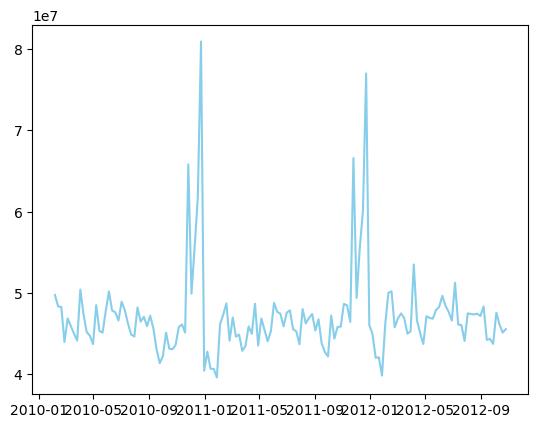

In [14]:
plt.plot(total_sales['Weekly_Sales'], color="skyblue")
plt.xlim()

In [15]:
df['Weekly_Sales'].describe()

count    6.435000e+03
mean     1.046965e+06
std      5.643666e+05
min      2.099862e+05
25%      5.533501e+05
50%      9.607460e+05
75%      1.420159e+06
max      3.818686e+06
Name: Weekly_Sales, dtype: float64

## CREACION DE LAGS Y ENTRENAMIENTO BASE

In [16]:
indices = [f"{i}({j})" for i in range(1, 144) for j in range(1, 46)]

df.index = indices


In [17]:
lags = 10  # Número de lags
total_sales_aux = total_sales.copy()
for i in range(1, lags + 1):
    total_sales_aux[f"lag_{i}"] = total_sales_aux["Weekly_Sales"].shift(i)

# Eliminar filas con valores faltantes en las nuevas columnas de lag
total_sales_aux.dropna(subset=[f"lag_{i}" for i in range(1, lags + 1)], inplace=True)

In [18]:
X2 = total_sales_aux[[f"lag_{i}" for i in range(1, lags + 1)]]
y2 = total_sales_aux["Weekly_Sales"]
X2

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10
Date,,,,,,,,,,
2010-04-16,47365290.44,50423831.26,44133961.05,44988974.64,45925396.51,46871470.30,43968571.13,48276993.78,48336677.63,49750740.50
2010-04-23,45183667.08,47365290.44,50423831.26,44133961.05,44988974.64,45925396.51,46871470.30,43968571.13,48276993.78,48336677.63
2010-04-30,44734452.56,45183667.08,47365290.44,50423831.26,44133961.05,44988974.64,45925396.51,46871470.30,43968571.13,48276993.78
2010-05-07,43705126.71,44734452.56,45183667.08,47365290.44,50423831.26,44133961.05,44988974.64,45925396.51,46871470.30,43968571.13
2010-05-14,48503243.52,43705126.71,44734452.56,45183667.08,47365290.44,50423831.26,44133961.05,44988974.64,45925396.51,46871470.30
...,...,...,...,...,...,...,...,...,...,...
2012-09-28,44354547.11,44226038.65,48330059.31,47159639.43,47447323.60,47354452.05,47403451.04,47485899.56,44097154.97,46059543.45
2012-10-05,43734899.40,44354547.11,44226038.65,48330059.31,47159639.43,47447323.60,47354452.05,47403451.04,47485899.56,44097154.97
2012-10-12,47566639.31,43734899.40,44354547.11,44226038.65,48330059.31,47159639.43,47447323.60,47354452.05,47403451.04,47485899.56


In [19]:
lags = 10  # Número de lags
df_aux = df.copy()
for i in range(1, lags + 1):
    df_aux[f"lag_{i}"] = df_aux["Weekly_Sales"].shift(i)

# Eliminar filas con valores faltantes en las nuevas columnas de lag
df_aux.dropna(subset=[f"lag_{i}" for i in range(1, lags + 1)], inplace=True)

In [20]:
X = df_aux[[f"lag_{i}" for i in range(1, lags + 1)]]
y = df_aux["Weekly_Sales"]
X

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10
1(11),2193048.75,549505.55,1004137.09,496725.44,1652635.10,317173.10,2135143.87,461622.22,2136989.46,1643690.90
1(12),1528008.64,2193048.75,549505.55,1004137.09,496725.44,1652635.10,317173.10,2135143.87,461622.22,2136989.46
1(13),1100046.37,1528008.64,2193048.75,549505.55,1004137.09,496725.44,1652635.10,317173.10,2135143.87,461622.22
1(14),1967220.53,1100046.37,1528008.64,2193048.75,549505.55,1004137.09,496725.44,1652635.10,317173.10,2135143.87
1(15),2623469.95,1967220.53,1100046.37,1528008.64,2193048.75,549505.55,1004137.09,496725.44,1652635.10,317173.10
...,...,...,...,...,...,...,...,...,...,...
143(41),921264.52,1569502.00,417290.38,534738.43,272489.41,865137.60,956987.81,253731.13,1219979.29,1340232.55
143(42),1316542.59,921264.52,1569502.00,417290.38,534738.43,272489.41,865137.60,956987.81,253731.13,1219979.29
143(43),514756.08,1316542.59,921264.52,1569502.00,417290.38,534738.43,272489.41,865137.60,956987.81,253731.13
143(44),587603.55,514756.08,1316542.59,921264.52,1569502.00,417290.38,534738.43,272489.41,865137.60,956987.81


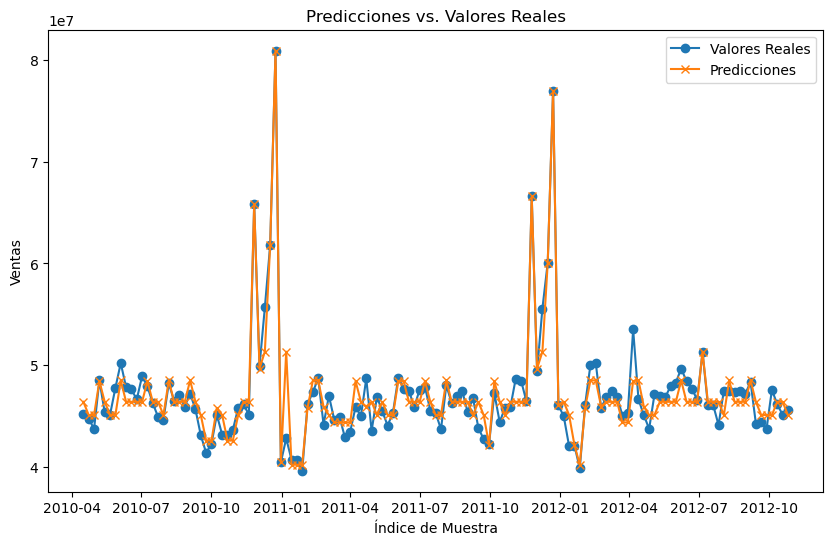

In [21]:
plt.rcParams['agg.path.chunksize'] = 200
# Crear y entrenar el modelo de árbol de decisión
modelo_arbol = DecisionTreeRegressor(max_depth=5)  # Puedes ajustar la profundidad máxima según tus necesidades
modelo_arbol.fit(X2, y2)
predicciones2 = modelo_arbol.predict(X2)
plt.figure(figsize=(10, 6))
plt.plot(y2.index,y2, label='Valores Reales', marker='o')
plt.plot(y2.index,predicciones2, label='Predicciones', marker='x')
plt.xlabel('Índice de Muestra')
plt.ylabel('Ventas')
plt.title('Predicciones vs. Valores Reales')

plt.legend()
plt.show()

Aunque el resultado no es perfecto es mas que aceptable pese a estar haciendo test con los datos de entrenamiento

In [22]:
plt.rcParams['agg.path.chunksize'] = 200
# Crear y entrenar el modelo de árbol de decisión
modelo_arbol = DecisionTreeRegressor(max_depth=5)  # Puedes ajustar la profundidad máxima según tus necesidades
modelo_arbol.fit(X, y)
predicciones = modelo_arbol.predict(X)

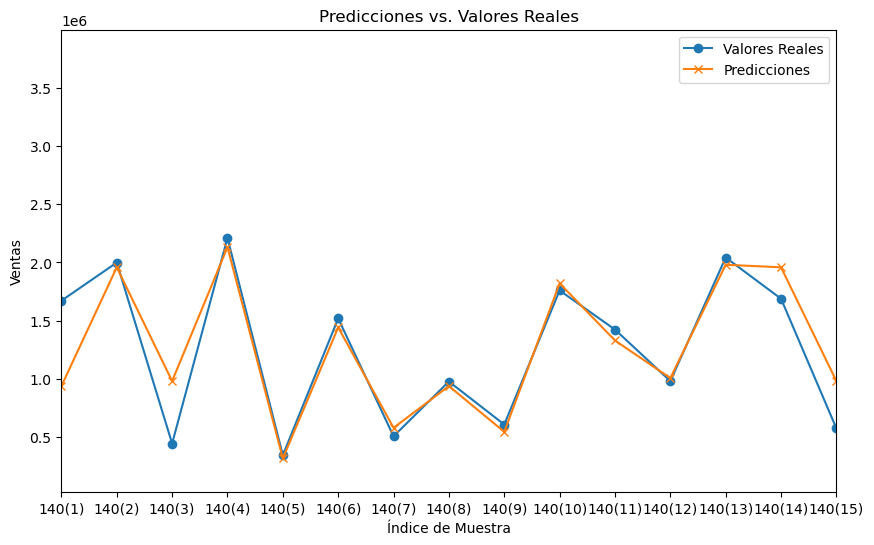

In [23]:
plt.figure(figsize=(10, 6))
plt.plot(y.index,y, label='Valores Reales', marker='o')
plt.plot(y.index,predicciones, label='Predicciones', marker='x')
plt.xlabel('Índice de Muestra')
plt.ylabel('Ventas')
plt.title('Predicciones vs. Valores Reales')
plt.xlim("140(1)", "140(15)")
plt.legend()
plt.show()

Al igual que con las suma de tiendas, el resultado es el esperado

In [24]:
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot

dfaux = X
dfaux['WeeklySales'] = y
dfaux2 = X2
dfaux2['WeeklySales'] = y2

In [25]:
dfaux

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,WeeklySales
1(11),2193048.75,549505.55,1004137.09,496725.44,1652635.10,317173.10,2135143.87,461622.22,2136989.46,1643690.90,1528008.64
1(12),1528008.64,2193048.75,549505.55,1004137.09,496725.44,1652635.10,317173.10,2135143.87,461622.22,2136989.46,1100046.37
1(13),1100046.37,1528008.64,2193048.75,549505.55,1004137.09,496725.44,1652635.10,317173.10,2135143.87,461622.22,1967220.53
1(14),1967220.53,1100046.37,1528008.64,2193048.75,549505.55,1004137.09,496725.44,1652635.10,317173.10,2135143.87,2623469.95
1(15),2623469.95,1967220.53,1100046.37,1528008.64,2193048.75,549505.55,1004137.09,496725.44,1652635.10,317173.10,652122.44
...,...,...,...,...,...,...,...,...,...,...,...
143(41),921264.52,1569502.00,417290.38,534738.43,272489.41,865137.60,956987.81,253731.13,1219979.29,1340232.55,1316542.59
143(42),1316542.59,921264.52,1569502.00,417290.38,534738.43,272489.41,865137.60,956987.81,253731.13,1219979.29,514756.08
143(43),514756.08,1316542.59,921264.52,1569502.00,417290.38,534738.43,272489.41,865137.60,956987.81,253731.13,587603.55
143(44),587603.55,514756.08,1316542.59,921264.52,1569502.00,417290.38,534738.43,272489.41,865137.60,956987.81,361067.07


In [26]:
dfaux2

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,WeeklySales
Date,,,,,,,,,,,
2010-04-16,47365290.44,50423831.26,44133961.05,44988974.64,45925396.51,46871470.30,43968571.13,48276993.78,48336677.63,49750740.50,45183667.08
2010-04-23,45183667.08,47365290.44,50423831.26,44133961.05,44988974.64,45925396.51,46871470.30,43968571.13,48276993.78,48336677.63,44734452.56
2010-04-30,44734452.56,45183667.08,47365290.44,50423831.26,44133961.05,44988974.64,45925396.51,46871470.30,43968571.13,48276993.78,43705126.71
2010-05-07,43705126.71,44734452.56,45183667.08,47365290.44,50423831.26,44133961.05,44988974.64,45925396.51,46871470.30,43968571.13,48503243.52
2010-05-14,48503243.52,43705126.71,44734452.56,45183667.08,47365290.44,50423831.26,44133961.05,44988974.64,45925396.51,46871470.30,45330080.20
...,...,...,...,...,...,...,...,...,...,...,...
2012-09-28,44354547.11,44226038.65,48330059.31,47159639.43,47447323.60,47354452.05,47403451.04,47485899.56,44097154.97,46059543.45,43734899.40
2012-10-05,43734899.40,44354547.11,44226038.65,48330059.31,47159639.43,47447323.60,47354452.05,47403451.04,47485899.56,44097154.97,47566639.31
2012-10-12,47566639.31,43734899.40,44354547.11,44226038.65,48330059.31,47159639.43,47447323.60,47354452.05,47403451.04,47485899.56,46128514.25


<Axes: xlabel='y(t)', ylabel='y(t + 1)'>

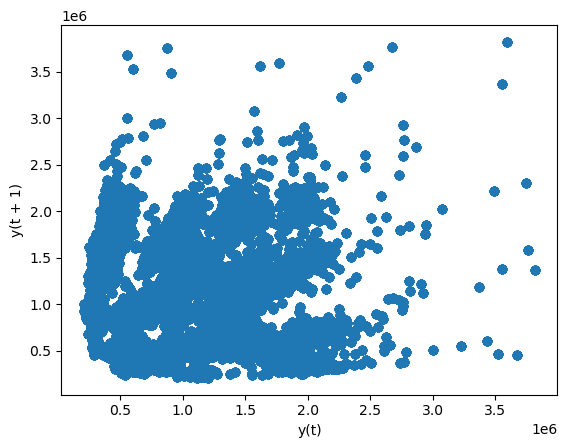

In [27]:
lag_plot(dfaux)

No tenemos una funcion clara lo que si esta claro es que tampoco parece random

<Axes: xlabel='y(t)', ylabel='y(t + 1)'>

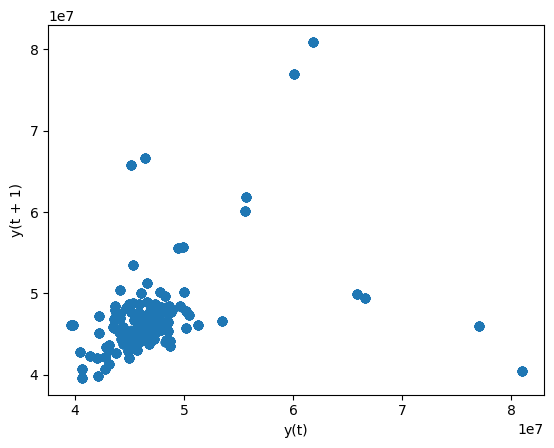

In [28]:
lag_plot(dfaux2)

aqui aunque tengamos menos datos si parece haber mas relacion

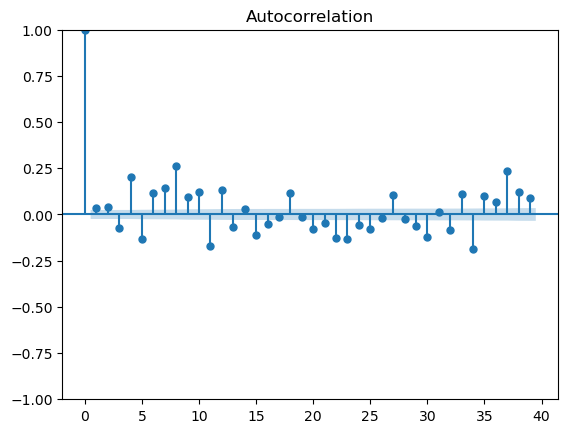

In [29]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df['Weekly_Sales']);

parece que nunca llegamos a 0 y siempre nos quedamos rangueando

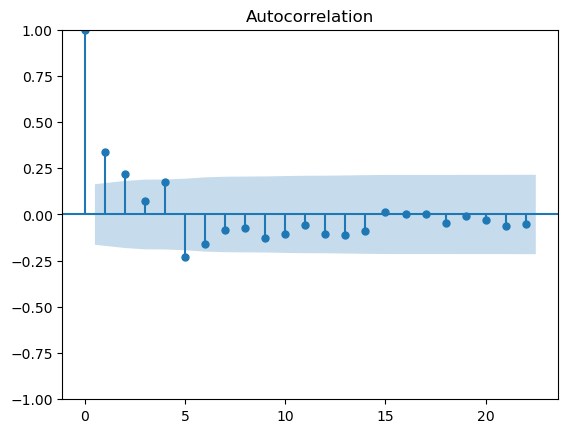

In [30]:
plot_acf(total_sales['Weekly_Sales']);

con el paso de los lags llegamos a un termino auroreg

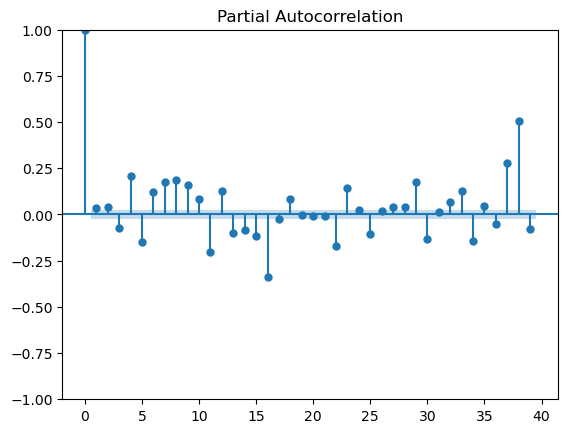

In [31]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(df['Weekly_Sales']);

igual que antes

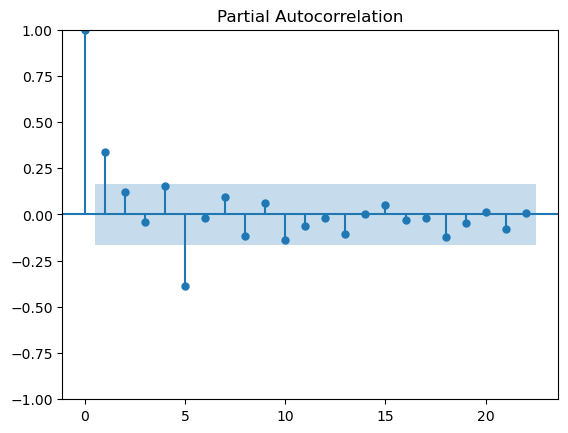

In [32]:
plot_pacf(total_sales['Weekly_Sales']);

mas correlacion

In [33]:
# Data manipulation
# ==============================================================================
import numpy as np
import pandas as pd

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline

# Modeling and Forecasting
# ==============================================================================
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.utils import save_forecaster
from skforecast.utils import load_forecaster

In [34]:
df2 = df.rename(columns={'Weekly_Sales': 'y'})
df2 = df2.reset_index()

df3 = total_sales.rename(columns={'Weekly_Sales': 'y'})



In [58]:
df3

,y
Date,
2010-02-05,49750740.50
2010-02-12,48336677.63
2010-02-19,48276993.78
2010-02-26,43968571.13
2010-03-05,46871470.30
...,...
2012-09-28,43734899.40
2012-10-05,47566639.31
2012-10-12,46128514.25


En este paso vamos a comenzar a separar en datos de train y test

para el grafico general

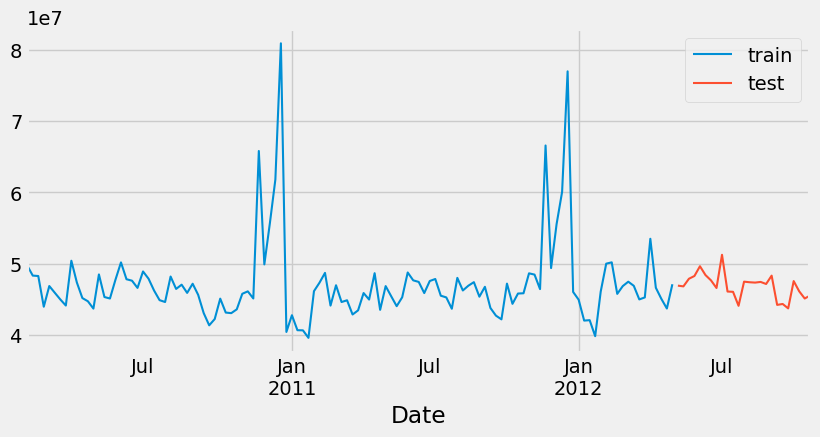

In [36]:
steps = 25
datos_train2 = df3[:-steps]
datos_test2  = df3[-steps:]
fig, ax = plt.subplots(figsize=(9, 4))
datos_train2['y'].plot(ax=ax, label='train')
datos_test2['y'].plot(ax=ax, label='test')
ax.legend();

In [59]:
datos_train2

,y
Date,
2010-02-05,49750740.50
2010-02-12,48336677.63
2010-02-19,48276993.78
2010-02-26,43968571.13
2010-03-05,46871470.30
...,...
2012-04-06,53502315.87
2012-04-13,46629261.41
2012-04-20,45072529.78


Hacemos el pred para el general

In [39]:
forecaster = ForecasterAutoreg(
                regressor =RandomForestRegressor(random_state=123) ,
                lags = 6
             )

forecaster.fit(y=datos_train2['y']) # cambiar el nombre de la variable objetivo
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [1 2 3 4 5 6] 
Transformer for y: None 
Transformer for exog: None 
Window size: 6 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [0, 117] 
Training index type: RangeIndex 
Training index frequency: 1 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
fit_kwargs: {} 
Creation date: 2023-10-03 18:05:17 
Last fit date: 2023-10-03 18:05:17 
Skforecast version: 0.10.1 
Python version: 3.8.18 
Forecaster id: None 

In [40]:
predicciones = forecaster.predict(steps=25)
pred = pd.DataFrame(predicciones)
pred = pred.set_index(datos_test2.index)

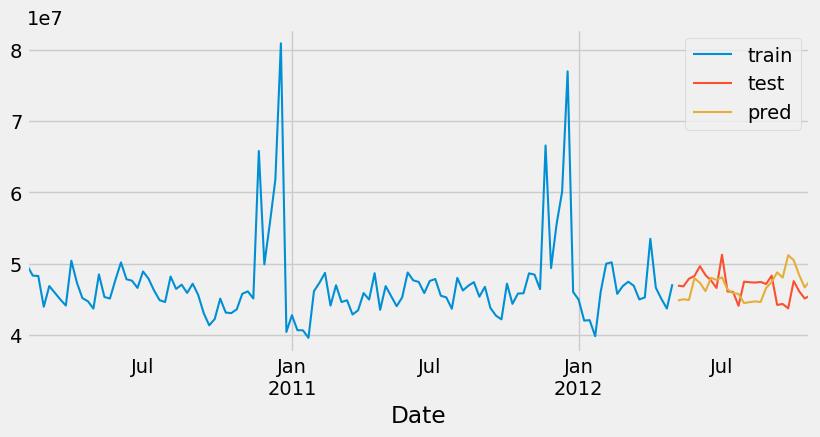

In [41]:
fig, ax = plt.subplots(figsize=(9, 4))
datos_train2['y'].plot(ax=ax, label='train')
datos_test2['y'].plot(ax=ax, label='test')
pred.plot(ax=ax, label='predicciones')

ax.legend();

In [42]:
from sklearn.metrics import mean_absolute_error
error_mse = mean_squared_error(
                y_true = datos_test2['y'],
                y_pred = predicciones
            )
y_true = datos_test2['y']
y_pred = predicciones
mae = mean_absolute_error(y_true, y_pred)
print(f"Error de test (mse) {error_mse}")
print(f"Error de test (mae) {mae}")

Error de test (mse) 7409431061291.508
Error de test (mae) 2235085.3953799973


un error medio de casi dos millones de ventas no esta mal teniendo en cuenta que la media es de unos 50 millones

y el pred para el extendido

la media es mas de un millon, u error medio de 70k no esta nada mal

In [61]:
from sklearn.neighbors import KNeighborsRegressor
forecaster = ForecasterAutoreg(
                regressor = KNeighborsRegressor(),
                lags = 6
             )

forecaster.fit(y=datos_train2['y']) # cambiar el nombre de la variable objetivo
forecaster

ForecasterAutoreg 
Regressor: KNeighborsRegressor() 
Lags: [1 2 3 4 5 6] 
Transformer for y: None 
Transformer for exog: None 
Window size: 6 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [0, 117] 
Training index type: RangeIndex 
Training index frequency: 1 
Regressor parameters: {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'} 
fit_kwargs: {} 
Creation date: 2023-10-03 19:44:45 
Last fit date: 2023-10-03 19:44:45 
Skforecast version: 0.10.1 
Python version: 3.8.18 
Forecaster id: None 

In [63]:
predicciones = forecaster.predict(steps=25)


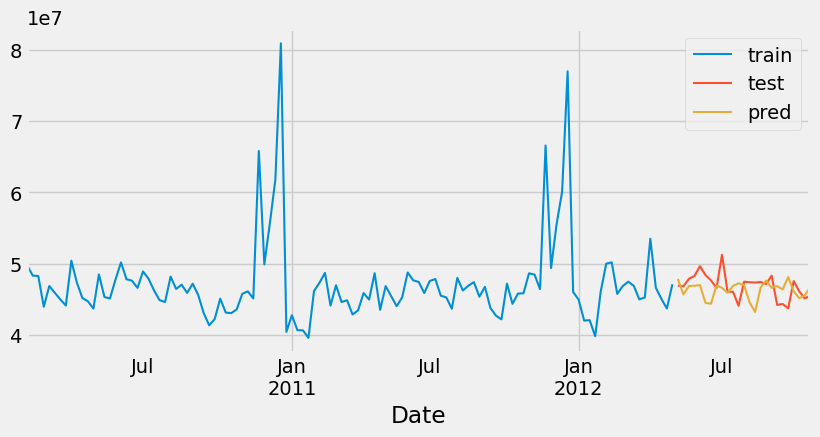

In [64]:
fig, ax = plt.subplots(figsize=(9, 4))
datos_train2['y'].plot(ax=ax, label='train')
datos_test2['y'].plot(ax=ax, label='test')
pred.plot(ax=ax, label='predicciones')

ax.legend();

In [65]:
from sklearn.metrics import mean_absolute_error
error_mse = mean_squared_error(
                y_true = datos_test2['y'],
                y_pred = predicciones
            )
y_true = datos_test2['y']
y_pred = predicciones
mae = mean_absolute_error(y_true, y_pred)
print(f"Error de test (mse) {error_mse}")
print(f"Error de test (mae) {mae}")

Error de test (mse) 5369637539262.853
Error de test (mae) 1874211.383680002


In [66]:
from sklearn import linear_model
forecaster = ForecasterAutoreg(                
                regressor = linear_model.Lasso(alpha=0.1),
                lags = 6
             )

forecaster.fit(y=datos_train2['y']) # cambiar el nombre de la variable objetivo
forecaster

ForecasterAutoreg 
Regressor: Lasso(alpha=0.1) 
Lags: [1 2 3 4 5 6] 
Transformer for y: None 
Transformer for exog: None 
Window size: 6 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [0, 117] 
Training index type: RangeIndex 
Training index frequency: 1 
Regressor parameters: {'alpha': 0.1, 'copy_X': True, 'fit_intercept': True, 'max_iter': 1000, 'positive': False, 'precompute': False, 'random_state': None, 'selection': 'cyclic', 'tol': 0.0001, 'warm_start': False} 
fit_kwargs: {} 
Creation date: 2023-10-03 19:47:55 
Last fit date: 2023-10-03 19:47:55 
Skforecast version: 0.10.1 
Python version: 3.8.18 
Forecaster id: None 

In [67]:
predicciones = forecaster.predict(steps=25)

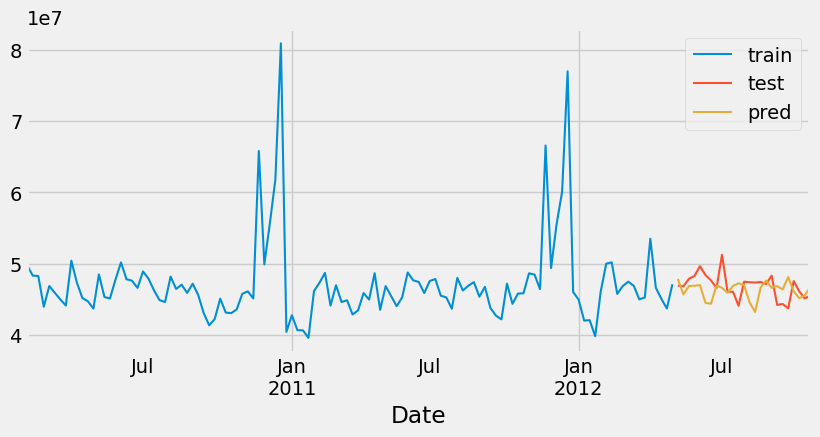

In [68]:
fig, ax = plt.subplots(figsize=(9, 4))
datos_train2['y'].plot(ax=ax, label='train')
datos_test2['y'].plot(ax=ax, label='test')
pred.plot(ax=ax, label='predicciones')

ax.legend();

In [69]:
from sklearn.metrics import mean_absolute_error
error_mse = mean_squared_error(
                y_true = datos_test2['y'],
                y_pred = predicciones
            )
y_true = datos_test2['y']
y_pred = predicciones
mae = mean_absolute_error(y_true, y_pred)
print(f"Error de test (mse) {error_mse}")
print(f"Error de test (mae) {mae}")

Error de test (mse) 3594190058339.26
Error de test (mae) 1479948.5642996416


### **EXPERIMENTO #2**

In [77]:
datos_train2.reset_index( inplace=True)

tenemos que hacer un grid search a ver si mejoramos el error en el modelo

In [80]:
steps = 25
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 6 # Este valor será remplazado en el grid search
             )

# Lags utilizados como predictores
lags_grid = [20]

# Hiperparámetros del regresor
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

param_grid = {'n_estimators': [20, 50, 100],
              'max_depth': [10, 20, 40 ]}

resultados_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = datos_train2['y'],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = steps,
                        refit              = True,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(datos_train2)*0.5),
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False
                   )

Number of models compared: 9.


lags grid:   0%|          | 0/1 [00:00<?, ?it/s]

params grid:   0%|          | 0/9 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
  Parameters: {'max_depth': 10, 'n_estimators': 50}
  Backtesting metric: 56847839493647.64



In [81]:
# Resultados Grid Search
# ==============================================================================
resultados_grid

,lags,params,mean_squared_error,max_depth,n_estimators
1,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'n_estimators': 50}",5.684784e+13,10,50
0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'n_estimators': 20}",5.715738e+13,10,20
3,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 20, 'n_estimators': 20}",5.810717e+13,20,20
6,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 40, 'n_estimators': 20}",5.810717e+13,40,20
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 20, 'n_estimators': 50}",5.846117e+13,20,50
7,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 40, 'n_estimators': 50}",5.846117e+13,40,50
5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 20, 'n_estimators': 100}",6.108832e+13,20,100
8,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 40, 'n_estimators': 100}",6.108832e+13,40,100
2,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'n_estimators': 100}",6.178563e+13,10,100


In [82]:
# Crear y entrenar forecaster con mejores hiperparámetros
# ==============================================================================
regressor = RandomForestRegressor(max_depth=10, n_estimators=50, random_state=123)
forecaster = ForecasterAutoreg(
                regressor = regressor,
                lags      = 20
             )

forecaster.fit(y=datos_train2['y'])

In [84]:
# Predicciones
# ==============================================================================
predicciones = forecaster.predict(steps=25)

In [85]:
pred = pd.DataFrame(predicciones)
pred = pred.set_index(datos_test2.index)
pred.head(5)

,pred
Date,
2012-05-11,4.481669e+07
2012-05-18,4.453002e+07
2012-05-25,4.427066e+07
2012-06-01,4.634161e+07
2012-06-08,4.638749e+07


In [90]:
datos_train2 = datos_train2.set_index(datos_train2['Date'])

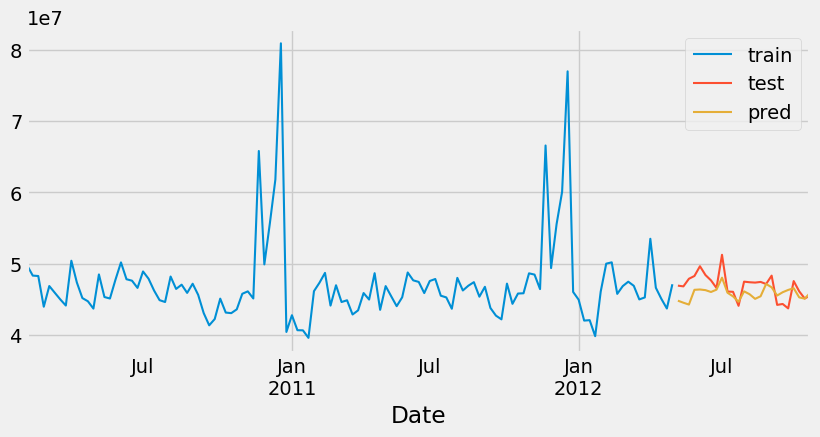

In [92]:
# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
datos_train2['y'].plot(ax=ax, label='train')
datos_test2['y'].plot(ax=ax, label='test')
pred.plot(ax=ax, label='predicciones')

ax.legend();

In [93]:
error_mse = mean_squared_error(
                y_true = datos_test2['y'],
                y_pred = pred
            )
y_true = datos_test2['y']
y_pred = pred
mae = mean_absolute_error(y_true, y_pred)
print(f"Error de test (mse) {error_mse}")
print(f"Error de test (mae) {mae}")

Error de test (mse) 3403817854597.358
Error de test (mae) 1542859.6018654257


### **EXPERIMENTO #3**

In [103]:
datos_train2.reset_index(drop = True, inplace = True)

In [104]:
datos_train2

,Date,y
0,2010-02-05,49750740.50
1,2010-02-12,48336677.63
2,2010-02-19,48276993.78
3,2010-02-26,43968571.13
4,2010-03-05,46871470.30
...,...,...
113,2012-04-06,53502315.87
114,2012-04-13,46629261.41
115,2012-04-20,45072529.78
116,2012-04-27,43716798.89


In [105]:
# Backtesting
# ==============================================================================
steps = 25
n_backtesting = 25*3 # Se separan para el backtest los últimos 9 años

metrica, predicciones_backtest = backtesting_forecaster(
                                    forecaster         = forecaster,
                                    y                  = datos_train2['y'],
                                    initial_train_size = len(datos_train2) - n_backtesting,
                                    fixed_train_size   = False,
                                    steps              = steps,
                                    refit              = True,
                                    metric             = 'mean_squared_error',
                                    verbose            = True
                                 )

print(f"Error de backtest: {metrica}")

Information of backtesting process
----------------------------------
Number of observations used for initial training: 43
Number of observations used for backtesting: 75
    Number of folds: 3
    Number of steps per fold: 25
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   0 -- 42  (n=43)
    Validation: 43 -- 67  (n=25)
Fold: 1
    Training:   0 -- 67  (n=68)
    Validation: 68 -- 92  (n=25)
Fold: 2
    Training:   0 -- 92  (n=93)
    Validation: 93 -- 117  (n=25)



  0%|          | 0/3 [00:00<?, ?it/s]

Error de backtest: 44031713801241.734


TypeError: index type not supported

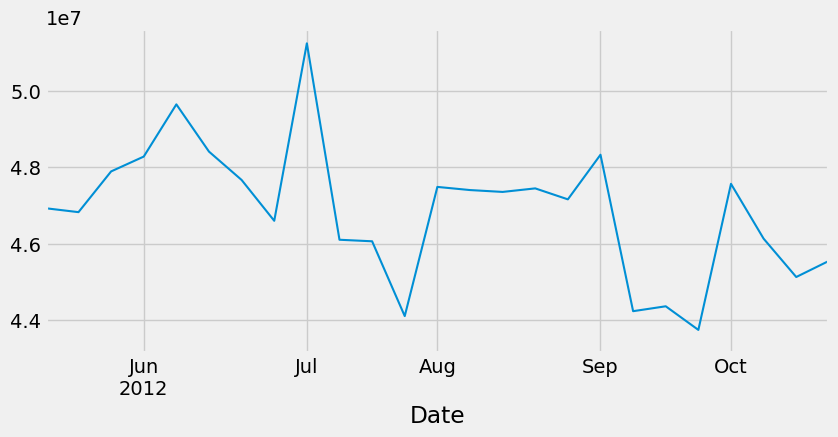

In [107]:
fig, ax = plt.subplots(figsize=(9, 4))
datos_test2['y'].plot(ax=ax, label='test')
predicciones_backtest.plot(ax=ax, label='predicciones')
ax.legend();

In [57]:
importancia = forecaster.get_feature_importances()
importancia

,feature,importance
0,lag_1,0.118278
1,lag_2,0.031146
2,lag_3,0.014831
3,lag_4,0.047750
4,lag_5,0.037538
5,lag_6,0.061592
6,lag_7,0.124722
7,lag_8,0.138485
8,lag_9,0.014756
9,lag_10,0.018786


## EXPERIMENTO 4